In [335]:
from __future__ import print_function
import sys
sys.path.append('../build/')
%pylab inline
np.set_printoptions(precision=4, suppress=True)
import versor as vsr
from versor.drawing import *
from motor_estimation import MotorEstimationSolver
import itertools
from copy import deepcopy

Populating the interactive namespace from numpy and matplotlib


/Users/lars/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Inf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [336]:
m1 = (vsr.Vec(1,2,3).unit() * 0.1 ).trs() * vsr.Rot(vsr.Biv(1,2,10).unit() * 0.2)
m2 = (vsr.Vec(-1,2,3).unit() * 1000 ).trs() * vsr.Rot(vsr.Biv(1,2,10).unit() * (-pi))

In [337]:
m1

Mot: [ 0.98 -0.019 -0.039 -0.19 -0.015 -0.034 -0.034 0.0023 ]

In [339]:
def generate_pointcloud_and_normals(n_samples, motor):
    
    bunny_xyz_file = join('bunny_data', 'bunny', 'reconstruction', 'bunnynormal.xyz')
    f = open(bunny_xyz_file)
    data = np.array([f.readline().split() for i in range(35947)]).astype(np.float64).tolist()
     = [data.pop(np.random.randint(0,len(points)-i)) for i in range(100)]
    f.close()
    
    sigma = 0.3
    points = [vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null() for i in range(n_samples)]
    normals = [vsr.Vec(*np.random.normal(0.0, 0.8, 3)).unit() for i in range(n_samples)]
    lines = [vsr.Dll(point, normal) for point, normal in zip(points, normals)]
    samples_1 = [(point, lines) for point, lines in zip(points, lines)]
    samples_2 = [(point.spin(motor), line.spin(motor)) for point, line in samples_1]
    
    points_noisy = [vsr.Vec(*(np.array(p)[:3] + sigma * np.random.randn(3))).null().spin(motor) 
                    for p in points]
    normals_noisy = [n.spin((vsr.Biv(*np.random.random(3)).unit() * np.random.random(1) * 0.7).exp()) 
                     for n in normals]
    lines_noisy = [vsr.Dll(point, normal)
                   for point, normal in zip(points_noisy, normals_noisy)]
    samples_3 = [(point, lines) for point, lines in zip(points_noisy, lines_noisy)]       
    return (samples_1, samples_2, samples_3)

In [296]:
A,B,C = generate_pointcloud_and_normals(1000,m1)

In [297]:
Acp = vsr.Vec(*(np.sum([np.array(p.vec()) for p,_ in A],axis=0) / len(A))).null()
Acl = vsr.Dll(*(np.sum([np.array(l) for _,l in A],axis=0) / len(A)))
Bcp = vsr.Vec(*(np.sum([np.array(p.vec()) for p,_ in B],axis=0) / len(B))).null()
Bcl = vsr.Dll(*(np.sum([np.array(l) for _,l in B],axis=0) / len(B)))
Ccp = vsr.Vec(*(np.sum([np.array(p.vec()) for p,_ in C],axis=0) / len(C))).null()
Ccl = vsr.Dll(*(np.sum([np.array(l) for _,l in C],axis=0) / len(C)))

In [298]:
print(Bcp)
print(Ccp)
print(Acl)
print(Bcl)
print(Ccl)

Pnt: [ 0.02558 -0.003774 0.06927 1 0.002733 ]
Pnt: [ 0.02886 -0.008271 0.07654 1 0.00338 ]
Dll: [ -0.013 0.02768 -0.02232 0.02257 -0.01116 0.035 ]
Dll: [ -0.02433 0.02113 -0.01988 0.02107 -0.02409 0.03042 ]
Dll: [ -0.02945 0.01374 -0.003869 0.01612 -0.0145 0.001906 ]


In [299]:
Ccl.biv().duale() <= Ccl.drv().vec()

8.07559275206703e-05

In [300]:
Bcl.biv().duale() <= Bcl.drv().vec()

-0.0006499266657411062

In [301]:
A[0][1].biv().duale() <= A[0][1].drv().vec()

-1.3877787807814457e-17

In [317]:
mes = MotorEstimationSolver(m2)
mes.add_point_correspondences_residual_block(Acp, Bcp)
mes.add_line_commutator_residual_block(Acl, Bcl)
# mes.add_line_correspondences_residual_block(Acl, Bcl)

# mes.max_num_iterations = 5
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
(motor, summary, _) = mes.solve()
print(m1)
print(motor)
print(summary['full_report'])

Mot: [ 0.98 -0.019 -0.039 -0.19 -0.015 -0.034 -0.034 0.0023 ]
Mot: [ -0.98 0.019 0.039 0.19 0.015 0.034 0.034 -0.0023 ]

Solver Summary (v 1.12.0-eigen-(3.3.1)-lapack-suitesparse-(4.5.3)-cxsparse-(3.1.9)-no_openmp)

                                     Original                  Reduced
Parameter blocks                            1                        1
Parameters                                  8                        8
Effective parameters                        6                        6
Residual blocks                             2                        2
Residual                                    9                        9

Minimizer                        TRUST_REGION

Dense linear algebra library            EIGEN
Trust region strategy     LEVENBERG_MARQUARDT

                                        Given                     Used
Linear solver                        DENSE_QR                 DENSE_QR
Threads                                     1                        1
Line

In [330]:
np.allclose(m1, motor*-1,rtol=1e-3)

True

In [322]:
m1

Mot: [ 0.98 -0.019 -0.039 -0.19 -0.015 -0.034 -0.034 0.0023 ]

In [324]:
motor*-1

Mot: [ 0.98 -0.019 -0.039 -0.19 -0.015 -0.034 -0.034 0.0023 ]

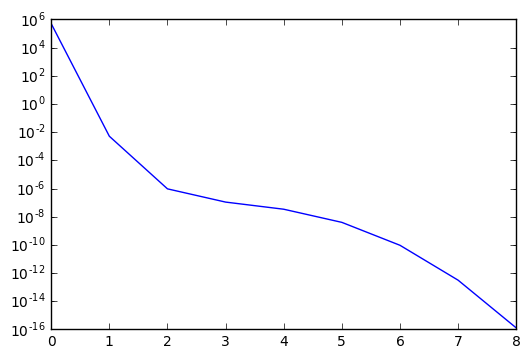

In [310]:
semilogy([it['cost'] for it in summary['iterations']])

In [311]:
m1 * motor.rev()

Mot: [ -1 3.6e-06 -1.1e-06 5.1e-06 -8.7e-08 2.6e-07 4.6e-08 8.7e-18 ]

In [312]:
l1 = vsr.Dll(vsr.Vec(0,0,1).null(), vsr.Vec(1,0,0))
l2 = vsr.Dll(vsr.Vec(1,0,0).null(), vsr.Vec(0,1,0))
l3 = vsr.Dll(vsr.Vec(0,1,0).null(), vsr.Vec(0,0,1))

In [274]:
l1mesh = line_mesh(l1, color='red')
l2mesh = line_mesh(l2, color='green')
l3mesh = line_mesh(l3, color='blue')

S1 = line_mesh((l1 + l2)*0.5, color='yellow')
S2 = line_mesh(((l1 +l2 + l3) * (1/3) ),color='purple')

ls = [l1mesh, l2mesh, l3mesh, S1, S2]
scene = Scene(children=[frame_mesh(), AmbientLight(color='#777777')] + ls)

camera = PerspectiveCamera(position=[0, 5, 5], up=[0, 0, 1],
                      children=[DirectionalLight(color='white', 
                                                 position=[3, 5, 1], 
                                                 intensity=0.5)])
renderer = Renderer(camera=camera, 
                    scene=scene, 
                    controls=[TrackballControls(controlling=camera)],
                    background = 'white')
renderer.width = '950'
renderer.height = '713'
display(renderer)

In [275]:
l1 + l2

Dll: [ 0 -1 1 0 1 1 ]

In [280]:
vsr.Vec(0,0,0).null().spin(((l1 + l2 + l3) * -0.5).exp())

Dls: [ 1 1 1 1 1.5 ]

In [281]:
vsr.Vec(1,1,1).null()

Pnt: [ 1 1 1 1 1.5 ]